# ResNets
- Experiments from different papers that analyse resnets

## Experiments
- plain vs resnet peformance with increasing depth (Deep Residual Learning for Image Recognition)
- Looking at weights, activations and gradients for deep plain vs resnets
- Gradient shattering on plain vs resnets (The shattered gradients problem: If resnets are the answer, then what is the question?)
- Removing layers at inference (Residual networks behave like ensembles of relatively shallow networks)
- Benchmark VGG13 vs ResNet101


## Conclusions
- Can reproduce results that plain networks deteriorate with increasing depth while resnets get better
- Introspection doesnt show that much. Only conclusion is that resnet weights decrease in magnitude in deeper networks while the opposite happens in plain networks. Gradients and activations seem to be more or less similar at varying depths.
- Managed to reproduce the gradient shattering problem on images using addition of input noise. Shattering is very pronounced in the beginning of training but then reduces in intencity after some epochs. Given that it reduces by itself perhpas it is not that important.
- Dropping random residual connections doesnt drastically affect accuracy (max 3-5%) unless it is in a downsampling layer
- VGG13 outperforms Resnet101 on Cifar10 under a standard setup

In [11]:
from my_utils import set_torch_seed

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import vgg13_bn, resnet101
from torchvision.datasets import CIFAR10

import copy
import numpy as np
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt

%matplotlib inline
%config Completer.use_jedi = False

# 1. Data
- CIFAR10

In [2]:
DATASET_ROOT = "/data/datasets/CIFAR10"


train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)


def get_loaders(batch_size=64):
    train_ds = CIFAR10(root=DATASET_ROOT, transform=train_transform, train=True)
    test_ds = CIFAR10(root=DATASET_ROOT, transform=test_transform, train=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

    return train_loader, test_loader

# 2. Training Setup
- Same augmentation as in Resnet paper
- Higher batchsize (512 instead of 128) - lower acc but faster
- Cosine annealing instead of stepwise lr reduction
- SGD lr 1e-1 for 200 epochs
- For quick eval use Adam (with cosine annealing), lr 3e-4 for 50 epochs.

In [3]:
criterion = nn.CrossEntropyLoss()
device="cuda:0"


def train(model, n_epochs=50, lr=3e-4, batch_size=512, optimiser="adam", introspect=True, **kwargs):
    model = copy.deepcopy(model).to(device).train()
    train_loader, test_loader = get_loaders(batch_size)
    logs = defaultdict(list)
    
    if optimiser == "adam":
        optimiser = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    elif optimiser == "sgd":
        optimiser = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=1e-4)
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=n_epochs)
    

    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        lr_scheduler.step()
        #logs["train_acc"].append(evaluate(model, train_loader))
        logs["test_acc"].append(evaluate(model, test_loader))
        if introspect:
                log_introspection(logs, model, X, y, layer_ix=1)
        pbar.set_description("Test Acc: {:.4f}%".format(logs['test_acc'][-1] * 100))
    return model.cpu().eval(), logs

def evaluate(model, loader) -> float:
    correct = 0
    n_obs = 0

    model.eval()
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            out = model(X)
        correct += (out.argmax(dim=1) == y).float().sum()
        n_obs += len(X)
    model.train()

    accuracy = correct / n_obs
    return accuracy.item()


def log_introspection(logs, model, X, y, layer_ix=1, filter_ix=0):
    model.zero_grad()
    model.eval()
    
    X, y = X.to(device), y.to(device)
    out = model(X)
    loss = criterion(out, y)
    loss.backward()
    
    weight = model.features[layer_ix].conv2.weight
    logs[f"w_{layer_ix}"].append((weight[filter_ix].norm(p=1) / weight[filter_ix].numel()).detach().cpu().item())
    logs[f"g_{layer_ix}"].append((weight.grad[filter_ix].norm(p=1) / weight[filter_ix].numel()).detach().cpu().item())
    
    out = X
    for i in range(layer_ix):
        out = model.features[i](out)
    block = model.features[layer_ix]
    out = block.relu1(block.bn1(block.conv1(out)))
    out = block.bn2(block.conv2(out))
    logs[f"o_{layer_ix}"].append((out[filter_ix].norm(p=1) / out[filter_ix].numel()).detach().cpu().item())
    
    model.train()

# 3. Architectures
- Plain
- Residual, no bottleneck 

In [4]:
class PlainBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, stride=False):
        stride = 2 if stride else 1
        features = OrderedDict([
            ("conv1", nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False, stride=stride)),
            ("bn1", nn.BatchNorm2d(out_channels)),
            ("relu1", nn.ReLU()),
            ("conv2", nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)),
            ("bn2", nn.BatchNorm2d(out_channels)),
            ("relu2", nn.ReLU())
        ])
        super().__init__(features)
        

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=False):
        super().__init__()
        
        skip = []
        if stride:
            skip += [
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=False, stride=2),
                nn.BatchNorm2d(out_channels)
            ]
        self.skip = nn.Sequential(*skip)
        
        stride = 2 if stride else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
    
    def forward(self, X):
        out1 = self.relu1(self.bn1(self.conv1(X)))
        out2 = self.relu2(self.bn2(self.conv2(out1)) + self.skip(X))
        return out2
        
        

class Model(nn.Module):
    def __init__(self, n=1, Block=PlainBlock):
        super().__init__()
        in_channels = out_channels = 16
        features = [nn.Conv2d(3, out_channels, kernel_size=3, padding=1, bias=False)]
        for stack in range(3):
            for i in range(n):
                features += [Block(in_channels, out_channels, stride=(stack > 0 and i == 0))]
                in_channels = out_channels
            out_channels *= 2
        self.features = nn.Sequential(*features)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(self._repr_size(), 10)
        initialize_weights(self) # works worse for some reason?
        
    def get_depth(self):
        return len([m for m in self.modules() if isinstance(m, nn.Conv2d)]) + 1 # + the linear?
        
    def _repr_size(self):
        self.eval()
        with torch.no_grad():
            out = self.features(torch.randn(1, 3, 32, 32))
            out = self.avg_pool(out)
        self.train()
        return out.numel()
    
    def forward(self, X):
        out = self.features(X)
        out = self.avg_pool(out)
        out = out.view(len(X), -1)
        out = self.classifier(out)
        return out
    
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
    return model

# 4. Accuracy and Introspection of Plain vs Resnets
- Reimplement experiments with increasing depth as in paper
- Add introspection on weights, activations and gradients on the first filter in the second conv layer (fist conv layer is outside of residual block)
- w (weights), o (output/activation), g (gradient) - Using normalized(mean) L1 norm 

In [ ]:
logs_plain = dict()
for n in [1, 3, 5, 7, 9]:
    set_torch_seed(0)
    model, logs = train(Model(n=n, Block=PlainBlock), n_epochs=200, optimiser="sgd", lr=1e-1)
    logs_plain[n] = logs

Test Acc: 89.6800%:  86%|████████▌ | 172/200 [26:10<04:15,  9.11s/it]

In [579]:
logs_resnet = dict()
for n in [1, 3, 5, 7, 9]:
    set_torch_seed(0)
    model, logs = train(Model(n=n, Block=ResidualBlock), n_epochs=200, optimiser="sgd", lr=1e-1)
    logs_resnet[n] = logs

Test Acc: 91.4300%: 100%|██████████| 200/200 [1:11:43<00:00, 21.52s/it]


In [372]:
depths = {n: Model(n=n).get_depth() for n in [1, 3, 5, 7, 9]}

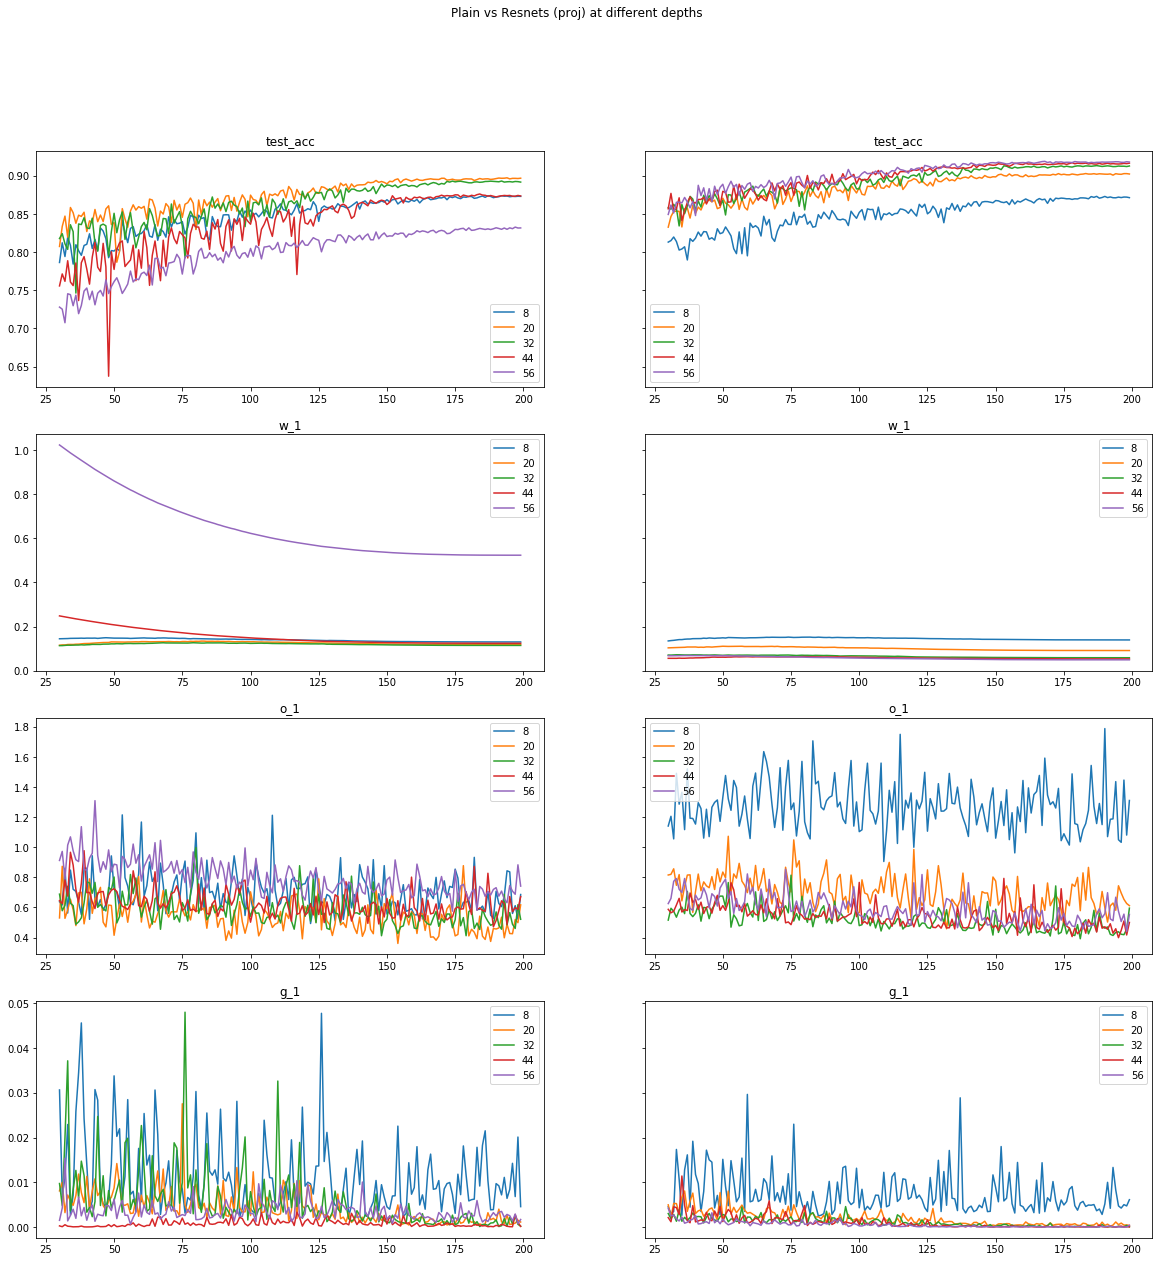

In [386]:
xlim = range(30, 200) # skipping first 30 epochs to zoom in 
f, axarr = plt.subplots(4, 2, figsize=(20, 20), sharey="row")
f.suptitle("Plain vs Resnets at different depths")
for i, metric in enumerate(["test_acc", "w_1", "o_1", "g_1"]):
    for j, logs in enumerate([logs_plain, logs_resnet]):
        axarr[i, j].set_title(metric)
        for n in [1, 3, 5, 7, 9]:
            axarr[i, j].plot(xlim, logs[n][metric][xlim[0]:], label=depths[n])
        axarr[i, j].legend()
plt.show()

# 5. Gradient Shattering
- Gradient from similar data points should be similar
- In the paper they use a toy example wich receives a continuous input - easy to find a similar point ($+\epsilon$)
- For CIFAR10 they do some sort of knn to obtain similar images, that seems a bit much though
- I propose a more simple way to test the gradient shattering hypothesis. 
- I will just add random noise to an image and compare its gradients (via cosine simialrity) to the gradients from the original image.
- The claim in the paper is that gradients in resent are more contiguous than in plain deep networks therefore if I plot the distribution of cosines (between an image and similar images) then that distribution should be biased towards 1, wheras for the plain deep network the graidents would be more biased towards 0
- Trying this for models that are trained and un-trained

In [566]:
def get_grad(model, X, y):
    """First filter in second conv laayer"""
    model.zero_grad()
    out = model(X)
    loss = criterion(out, y)
    grad = torch.autograd.grad(loss, model.features[1].conv1.weight)
    return grad[0].view(-1)

def get_grad_similarity_distribution(model, X, y, num=1000) -> list:
    res = []
    ref = get_grad(model, X, y)
    for _ in range(num):
        grad = get_grad(model, X + 1e-2 * torch.randn_like(X), y)
        res.append(torch.cosine_similarity(ref, grad, dim=-1).item())
    return res

train_loader, test_loader = get_loaders()
X, y = next(iter(train_loader))
X, y = X[0].unsqueeze(0), y[0].unsqueeze(0)

std plain: 1.3134148614136542e-36, std resnet: 0.001850247577099375


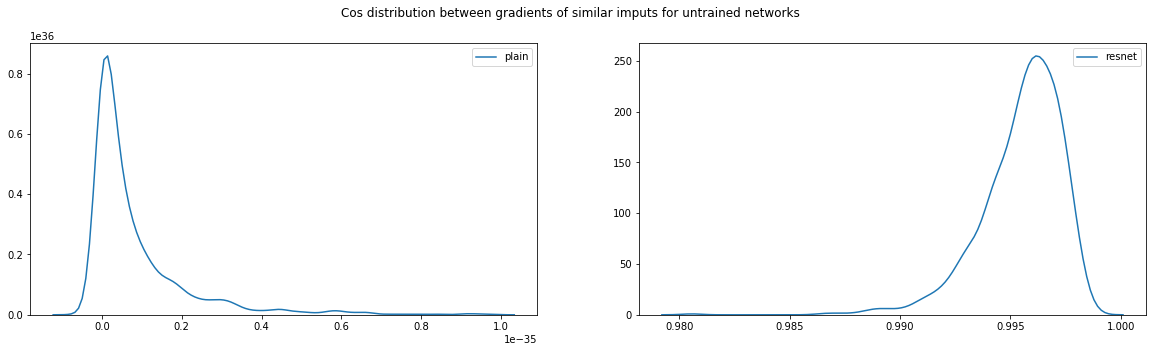

In [576]:
plain = Model(n=9, Block=PlainBlock).eval()
resnet = Model(n=9, Block=ResidualBlock).eval()


plain_dist = get_grad_similarity_distribution(plain, X, y)
resnet_dist = get_grad_similarity_distribution(resnet, X, y)

f, axarr = plt.subplots(1, 2, figsize=(20, 5))
f.suptitle("Cos distribution between gradients of similar imputs for untrained networks")
sns.kdeplot(plain_dist, label="plain", ax=axarr[0])
sns.kdeplot(resnet_dist, label="resnet", ax=axarr[1])
print(f"std plain: {np.std(plain_dist)}, std resnet: {np.std(resnet_dist)}")

Test Acc: 72.6000%: 100%|██████████| 10/10 [03:34<00:00, 21.42s/it]


std plain: 0.14989939989963197, std resnet: 0.010650289948307658


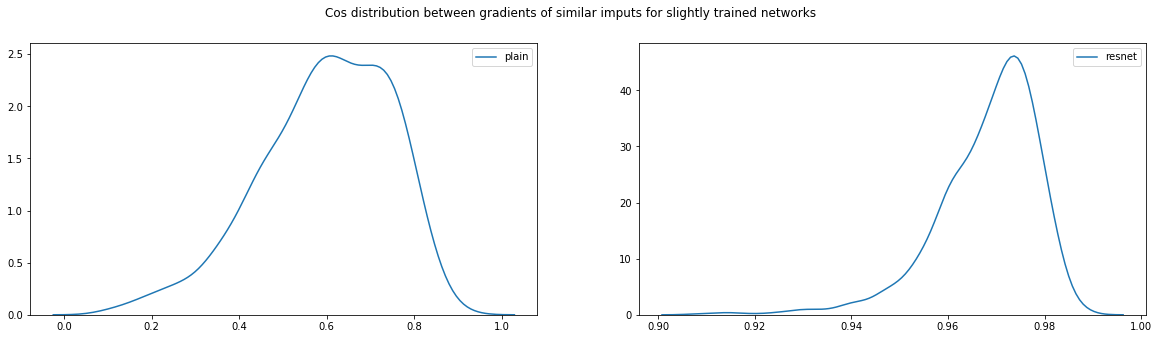

In [577]:
plain, _ = train(Model(n=9, Block=PlainBlock), n_epochs=10, optimiser="adam", lr=3e-4)
resnet, _ = train(Model(n=9, Block=ResidualBlock), n_epochs=10, optimiser="adam", lr=3e-4)

plain_dist = get_grad_similarity_distribution(plain, X, y)
resnet_dist = get_grad_similarity_distribution(resnet, X, y)

f, axarr = plt.subplots(1, 2, figsize=(20, 5))
f.suptitle("Cos distribution between gradients of similar imputs for slightly trained networks")
sns.kdeplot(plain_dist, label="plain", ax=axarr[0])
sns.kdeplot(resnet_dist, label="resnet", ax=axarr[1])
print(f"std plain: {np.std(plain_dist)}, std resnet: {np.std(resnet_dist)}")

# 5. Layer Deletion
- Deleting one resnet block and seeing how performance changes 
- The residual connection is set to 0., skip connection is the only source
- Turns out model pretty robust except when the blocks are pooling ones

In [ ]:
set_torch_seed(0)
model, logs = train(Model(n=9, Block=ResidualBlock), n_epochs=200, optimiser="sgd", lr=1e-1)

In [581]:
_, test_loader = get_loaders(batch_size=1000)

In [625]:
def delete_block(model, block: int):
    model = copy.deepcopy(model)
    residual_blocks = [m for m in model.modules() if isinstance(m, ResidualBlock)]
    nn.init.constant_(residual_blocks[block].bn2.weight, 0)
    nn.init.constant_(residual_blocks[block].bn2.bias, 0)
    return model


# Test
new_ = delete_block(model, 0)
in_ = torch.randn(1, 16, 32, 32)
out_ = new_.features[1](in_)
torch.equal(out_, nn.functional.relu(in_))

True

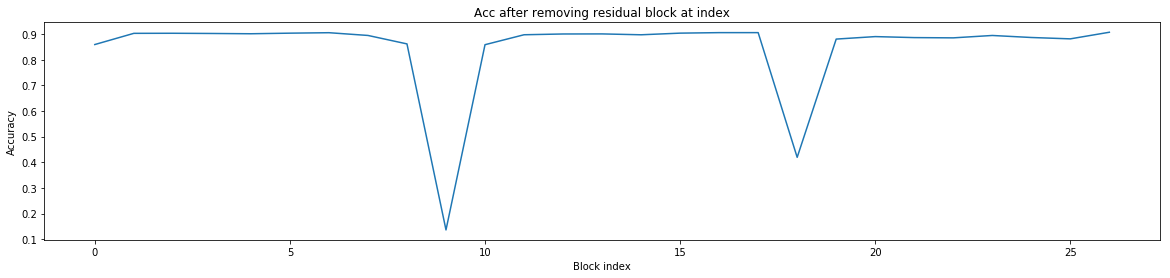

In [644]:
res = []
n_blocks = len([m for m in model.modules() if isinstance(m, ResidualBlock)])
for ix in range(n_blocks):
    pruned = delete_block(model, ix)
    acc = evaluate(pruned.to(device), test_loader)
    res.append(acc)
    
plt.figure(figsize=(20, 4))
plt.title("Acc after removing residual block at index")
plt.xlabel("Block index")
plt.ylabel("Accuracy")
plt.plot(res)
plt.show()

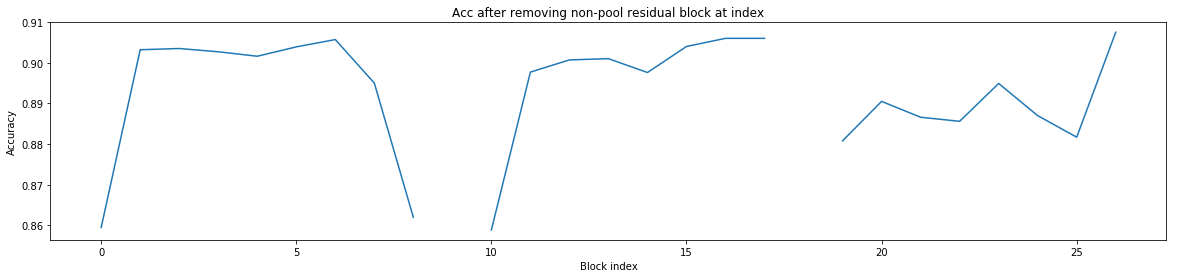

In [647]:
res = []
n_blocks = len([m for m in model.modules() if isinstance(m, ResidualBlock)])
for ix in range(n_blocks):
    if len(model.features[ix+1].skip) > 0:
        res.append(np.NaN)
        continue
    pruned = delete_block(model, ix)
    acc = evaluate(pruned.to(device), test_loader)
    res.append(acc)
    
plt.figure(figsize=(20, 4))
plt.title("Acc after removing non-pool residual block at index")
plt.xlabel("Block index")
plt.ylabel("Accuracy")
plt.plot(res)

# 6. Resnet vs VGG Benchmark
- Using the torchvision vgg13 and resnet101 models
- They are setup for imagenet and have a 1000 fc output, but would run for cifar10 inputs
- Made some modifications to the models for cifar10 (resnet starts with a 7x7 conv + maxpool in imagenet) including logit size
- In the resnet paper they say on cifar to start with a lower lr then bump it up and then down again but meh.
- Under this standard setup vgg performs better, in line with other ppl's benchmakrs 

In [5]:
def get_resnet():
    model = resnet101(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
    model.maxpool = nn.Sequential()
    model.fc = nn.Sequential(nn.Linear(2048, 10))
    return model

def get_vgg():
    model = vgg13_bn(pretrained=False)
    model.features = model.features[:-1]  # dropping the last maxpool
    model.avgpool = nn.AvgPool2d(kernel_size=2)
    model.classifier = nn.Sequential(nn.Linear(512, 10))
    return model

In [6]:
set_torch_seed(0)
res_model, res_logs = train(get_resnet(), n_epochs=200, optimiser="sgd", lr=1e-1, introspect=False, batch_size=256)

Test Acc: 92.9300%: 100%|██████████| 200/200 [9:16:41<00:00, 167.01s/it]  


In [ ]:
set_torch_seed(0)
vgg_model, vgg_logs = train(get_vgg(), n_epochs=200, optimiser="sgd", lr=1e-1, introspect=False, batch_size=256)

Test Acc: 74.5800%:   2%|▏         | 3/200 [00:46<50:28, 15.37s/it]

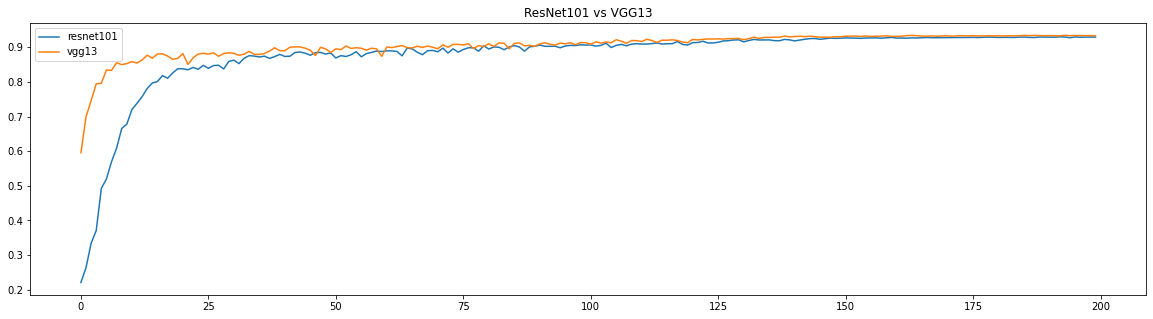

In [14]:
plt.figure(figsize=(20, 5))
plt.title("ResNet101 vs VGG13")
plt.plot(res_logs["test_acc"], label="resnet101")
plt.plot(vgg_logs["test_acc"], label="vgg13")
plt.legend()
plt.show()

In [23]:
print(f'Final Resnet101 Acc: {res_logs["test_acc"][-1] * 100:.2f}%, Final VGG13 acc {vgg_logs["test_acc"][-1] * 100:.2f}%')

Final Resnet101 Acc: 92.93%, Final VGG13 acc 93.34%
